# This is an example notebook to plot theta² using DL3 files in custom energy bins

It customizes the Gammapy functions make_theta_squared_table

Content:

#### 1. Read the given DL3 files

#### 2. Data selection masks

#### 3. Custom theta2 functions, to create a theta2 table and plot it

#### 4. Enter the inputs for the custom theta2 functions

#### 5. Plot theta2 distribution for each observation

#### 6. Theta2 plot for stacked observations (On/Off distributions)

#### 7. Plot just the excess counts


Created by **Chaitanya Priyadarshi** for the previous LST Analysis School and adapted to be used with newly created DL3 files (v0.10.x)

This is another example of creating theta2 plots, by using the standard function in Gammapy v1.3, and customizing it to use custom energy bins and custom wobble positions for wobble observations. It also adds the CTA outreach approved style for the plots, and separates the counts plots and the excess plots for easy visualization.

By default, the OFF theta2 profile is extracted from a mirror position radially symmetric in the FOV to pos_on. The ON and OFF regions are assumed to be of the same size, so the normalisation factor between both regions, alpha = 1.

One can either plot theta2 for stacked observations or single observations.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.colors as colors

import numpy as np
import regions
from regions import CircleSkyRegion
from scipy.stats import chi2
from pathlib import Path
import os
from glob import glob

In [19]:
from gammapy.data import DataStore, EventList
from gammapy.maps import Map, MapAxis, WcsNDMap, WcsGeom
from gammapy.data import DataStore
from gammapy.stats import WStatCountsStatistic
from gammapy.maps.utils import edges_from_lo_hi

import astropy.units as u
from astropy.table import Table, Column, vstack
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle
from astropy.io.fits.verify import VerifyWarning

import warnings
warnings.filterwarnings("ignore")

from gammapy import __version__ as gammapy_version
print(f"Using Gammapy {gammapy_version}")

Using Gammapy 1.3


# 1. Get directory of DL3 files and source information to make the plots

In [20]:
dl3_path = Path('/fefs/aswg/workspace/analysis-school-2024/DL3/BLLac_20221020')
datastore = DataStore.from_dir(dl3_path)
plot_path = dl3_path / 'plots/theta2/'
plot_path.mkdir(exist_ok=True, parents=True)

In [21]:
# Assuming there is only 1 unique source in the DL3 files in this directory
obj_name = np.unique(datastore.obs_table["OBJECT"])[0]

target_position = SkyCoord.from_name("Crab")

In [22]:
datastore.obs_table

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes8,int64,bytes5,bytes5
7253,2022-03-04,20:40:32.241,2022-03-04,21:00:38.372,83.97943062930638,22.25335353937056,13.422090449856995,76.577909550143,243.77302906618937,83.6287,22.0147,108074432.24060129,108075638.37241745,1204.1316094398499,1206.131816163659,1127.458589873191,0.9363250503802267,Crab,POINTING,1,LST-1,LST-1
7254,2022-03-04,21:05:30.240,2022-03-04,21:25:37.400,83.29050952161744,21.800948969297423,19.19802110778498,70.80197889221502,253.2013551061538,83.6287,22.0147,108075930.23979044,108077137.4001336,1206.1613066196442,1207.1603431552649,1131.9816434865672,0.9384993841818962,Crab,POINTING,1,LST-1,LST-1
7255,2022-03-04,21:36:06.784,2022-03-04,21:51:56.982,83.28884041925919,21.795674035483536,25.382208300208376,64.61779169979162,260.294955425511,83.6287,22.0147,108077766.7842691,108078716.9818182,949.1999034881592,950.1975491046906,892.2200721091467,0.9399706730166948,Crab,POINTING,1,LST-1,LST-1
7256,2022-03-04,21:53:11.638,2022-03-04,22:01:18.297,83.99649640353842,22.253144615898247,27.48715298629486,62.51284701370514,263.19187880647183,83.6287,22.0147,108078791.63762784,108079278.29743028,488.2733657360077,486.6598024368286,460.0488355058822,0.9421952287166417,Crab,POINTING,1,LST-1,LST-1
7274,2022-03-05,20:53:16.930,2022-03-05,21:06:49.143,83.98539185966314,22.254379065092863,16.12996790347735,73.87003209652265,249.93492053037025,83.6287,22.0147,108161596.9301107,108162409.14250802,812.2127141952515,812.2123973220587,760.2431205417399,0.9360147991465468,Crab,POINTING,1,LST-1,LST-1
7275,2022-03-05,21:38:18.716,2022-03-05,21:58:23.093,83.28791947345997,21.79561204916476,27.038843859354152,62.96115614064585,261.73661487061315,83.6287,22.0147,108164298.71595024,108165503.09317039,1204.3778808116913,1204.3772201538086,1132.6497132578713,0.9404438019855705,Crab,POINTING,1,LST-1,LST-1
7276,2022-03-05,21:59:37.867,2022-03-05,22:06:23.829,83.99638507363059,22.249503340909264,29.64365025151926,60.35634974848074,264.80035457283583,83.6287,22.0147,108165577.8670981,108165983.82916166,405.96385622024536,405.96206356585026,382.8182559135567,0.9429860566352203,Crab,POINTING,1,LST-1,LST-1
7277,2022-03-05,22:09:31.561,2022-03-05,22:25:03.333,83.99927261174497,22.255142969772844,32.699115541157525,57.300884458842475,266.8437351536349,83.6287,22.0147,108166171.5613649,108167103.33252645,930.7727062702179,931.7711615413427,881.322852049584,0.9468722558283978,Crab,POINTING,1,LST-1,LST-1


# 2. Data selection masks

In [23]:
min_livetime = 300 #in sec
max_zen = 60

print('Total runs:', len(datastore.obs_table))

d_time = [datastore.obs_table["LIVETIME"]>min_livetime]
print(f'Number of runs with more than {min_livetime/60.:.1f} min data:', d_time[0].sum())

d_zen = [datastore.obs_table["ZEN_PNT"]<max_zen]
print(f'Number of runs with zenith less than {max_zen} deg:', d_zen[0].sum())

d_obj = [datastore.obs_table["OBJECT"]==obj_name]
print(f'Number of runs with source {obj_name}:', d_obj[0].sum())

Total runs: 8
Number of runs with more than 5.0 min data: 8
Number of runs with zenith less than 60 deg: 8
Number of runs with source Crab: 8


In [24]:
# Selecting only some runs based on previous filters
obs_table = datastore.obs_table[d_zen[0]*d_obj[0]*d_time[0]]
#obs_table = datastore.obs_table[d_obj[0]*d_time[0]]
obs_list = datastore.obs_table[d_zen[0]*d_obj[0]*d_time[0]]["OBS_ID"]

observations = datastore.get_observations(
    obs_list,
    required_irf="point-like"
)

In [25]:
print("The list of runs selected are", obs_list.data)

The list of runs selected are [7253 7254 7255 7256 7274 7275 7276 7277]


In [26]:
print(f'Total livetime: {datastore.obs_table["LIVETIME"].sum()/3600:.1f} hrs')
print(f'Total livetime of selected observations: {obs_table["LIVETIME"].sum()/3600:.1f} hrs')

Total livetime: 1.9 hrs
Total livetime of selected observations: 1.9 hrs


# 3. Custom theta2 functions, to create a theta2 table and plot it

In [27]:
def make_theta_squared_table(
    observations, theta_squared_axis, e_reco_axis, theta2_norm_min, theta2_norm_max,
    position_on, position_off=None, wobble_pos=None, n_wobbles=4
):
    """
    Make theta squared distribution in the same FoV for a list of wobble `Observation` objects.
    
    The ON theta2 profile is computed from a given distribution, on_position. By default, 
    the OFF theta2 profile is extracted from a mirror position radially symmetric in the FOV to pos_on.
    
    The ON and OFF regions are assumed to be of the same size, so the normalisation
    factor between both region alpha = 1.
    
    Parameters
    ----------
    observations: `~gammapy.data.Observations`
        List of observations
    theta_squared_axis: `~gammapy.maps.geom.MapAxis`
        Axis of edges of the theta2 bin used to compute the distribution
    e_reco_axis: `~gammapy.maps.geom.MapAxis`
        Axis of edges of the reco energy bin used to compute the distribution
    theta2_norm_min: 'float'
        Minimum theta2 edge for normalization
    theta2_norm_max: 'float'
        Maximum theta2 edge for normalization
    position_on: `~astropy.coordinates.SkyCoord`
        Position from which the ON theta^2 distribution is computed
    position_off: `astropy.coordinates.SkyCoord`
        Position from which the OFF theta^2 distribution is computed.
        Default: reflected position w.r.t. to the pointing position
    wobble_pos: 'array' or 'List'
        Array or List of wobble positions to consider for OFF regions. 
        1,2,3 corresponding to 90, 180, 270 deg from the source position
        This is in the case a specific OFF position is not provided
        Default: [2]
    n_wobbles: 'int'
        Maximum number of wobbles to be considered, while making the selection of the
        wobble indices, chosen for OFF counts.
        Default: 4

    Returns
    -------
    table : `~astropy.table.Table`
        Table containing the ON counts, the OFF counts, acceptance, off acceptance, alpha and the statistics
        for each bin.
    """

    table = Table()

    table["theta2_min"] = [theta_squared_axis.edges[:-1]]
    table["theta2_max"] = [theta_squared_axis.edges[1:]]
    table["ereco_min"] = [e_reco_axis.edges[:-1]]
    table["ereco_max"] = [e_reco_axis.edges[1:]]
    table["counts"] = [np.zeros((e_reco_axis.nbin,theta_squared_axis.nbin))]
    table["counts_off"] = [np.zeros((e_reco_axis.nbin,theta_squared_axis.nbin))]
    table["acceptance"] = [np.zeros(e_reco_axis.nbin)]
    table["acceptance_off"] = [np.zeros(e_reco_axis.nbin)]
    table["n_sig"] = [np.zeros((e_reco_axis.nbin,theta_squared_axis.nbin))]
    table["sqrt_ts"] = [np.zeros((e_reco_axis.nbin,theta_squared_axis.nbin))]
    table["excess_errp"] = [np.zeros((e_reco_axis.nbin,theta_squared_axis.nbin))]
    table["excess_errn"] = [np.zeros((e_reco_axis.nbin,theta_squared_axis.nbin))]
    table["p_value"] = [np.zeros((e_reco_axis.nbin,theta_squared_axis.nbin))]
    
    list_obs=[]
    counts_all_off=[]
    
    livetime_total = 0

    ereco_edges = edges_from_lo_hi(table["ereco_min"].quantity[0], table["ereco_max"].quantity[0])
    
    # Get the indices of the normalization region in the theta2 axis, from the values provided
    t2_norm_min_idx = np.where(theta_squared_axis.edges.value == theta2_norm_min)[0][0]
    t2_norm_max_idx = np.where(theta_squared_axis.edges.value == theta2_norm_max)[0][0]
    
    create_off = position_off is None
    
    # Iterate over all observations
    for observation in observations:
        list_obs.append(observation.obs_id)
        
        # ON counts
        separation = position_on.separation(observation.events.radec)
        ereco = observation.events.energy
        counts_on, _, _ = np.histogram2d(
            ereco, separation ** 2, 
            bins = (e_reco_axis.edges, theta_squared_axis.edges)
        )
        
        table["counts"][0] += counts_on
        table["acceptance"][0] += np.sum(counts_on[:,t2_norm_min_idx:t2_norm_max_idx], axis=1)
        
        if create_off:
            # Estimate the position of the mirror position
            pos_angle = observation.get_pointing_icrs(observation.tmid).position_angle(position_on)
            sep_angle = observation.get_pointing_icrs(observation.tmid).separation(position_on)
            
            # Calculate the OFF counts from the wobble positions (OFF regions) provided
            for i in wobble_pos:
               position_off = observation.get_pointing_icrs(observation.tmid).directional_offset_by(
                            pos_angle + Angle(2*i*np.pi/n_wobbles, "rad"), sep_angle
                )
               # Angular distance of the events from the mirror position
               separation_off = position_off.separation(observation.events.radec)

               counts_off_wob, _, _ = np.histogram2d(
                    ereco, separation_off ** 2, 
                    bins = (e_reco_axis.edges, theta_squared_axis.edges)
                )
               counts_all_off.append(counts_off_wob)
                
        counts_off=np.sum(counts_all_off, axis=0)/len(wobble_pos)
        
        table["counts_off"][0] += counts_off
        
        # Normalisation between ON and OFF is one
        table["acceptance_off"][0] += np.sum(counts_off[:, t2_norm_min_idx:t2_norm_max_idx], axis=1)
        
        livetime_total += observation.observation_live_time_duration.to_value("s")

    table["obs_id"]=[list_obs]
    table["n_wobbles"] = [wobble_pos]
    table["alpha"] = [table["acceptance"][0] / table["acceptance_off"][0]]
    table["livetime_total"] = [livetime_total]
    
    # normalized background rate
    table["bkg_rate"] = [table["counts_off"][0] / table["livetime_total"][0] * 60]
    
    for i in np.arange(e_reco_axis.nbin):
        table["bkg_rate"][0][i] *= table["alpha"][0][i]
        
        # Calculate the Statistics
        stat = WStatCountsStatistic(
            table["counts"][0][i], table["counts_off"][0][i], 
            np.repeat(table["alpha"][0][i], theta_squared_axis.nbin)
        )
        if np.all(np.isfinite(stat.sqrt_ts)):
            table["n_sig"][0][i] = stat.n_sig # Excess
            table["sqrt_ts"][0][i] = stat.sqrt_ts # Significance

            table["excess_errn"][0][i] = stat.compute_errn()
            table["excess_errp"][0][i] = stat.compute_errp()
            table["p_value"][0][i] = chi2.sf(stat.n_sig, 1)
        else:
            print(f'Non finite values in stats for {ereco_edges[i]}')
            table["n_sig"][0][i] = stat.n_sig
            table["sqrt_ts"][0][i] = stat.sqrt_ts
    
    return table

In [28]:
def plot_theta_squared_table(table, theta2_cut, custom_style=None, counts_only=None):
    """
    Plot the theta2 distribution of ON, OFF counts, excess and significance in each theta2bin 
    from the provided filled Theta2 Table.
    
    Parameters
    ----------
    table: `~astropy.table.Table`
        Required columns: theta2_min, theta2_max, counts, counts_off and alpha
    theta2_cut: 'float'
        Theta2 cut on the theta2 axis
    custom_style: 'Bool'
        For the plot style to be CTAO outreach-approved
    counts_only: 'Bool'
        True for only plotting counts distributions.
        False for only plotting excess distribution.
    """
    
    # Create MapAxis objects of the axes
    theta2_edges = edges_from_lo_hi(table["theta2_min"].quantity[0], table["theta2_max"].quantity[0])
    
    theta2_axis = MapAxis.from_edges(
        theta2_edges, interp="lin", name="theta_squared"
    )
    ereco_edges = edges_from_lo_hi(table["ereco_min"].quantity[0], table["ereco_max"].quantity[0])
    
    ereco_axis = MapAxis.from_edges(
        ereco_edges, interp="lin", name="reco_energy"
    )
    
    total_time = table["livetime_total"][0]/3600
    table["Sig_LiMa"] = table["alpha"] # to have the same shape for each energy bin
    bin_cut = np.where(theta2_edges==theta2_cut)[0][0]
    
    # The Li&Ma formula for calculating the significance:
    #alpha = table["alpha"][0]
    #N_on = np.sum(table["counts"][:bin_cut])
    #N_off = np.sum(table["counts_off"][:bin_cut])
    
    #S = np.sqrt(2 * (N_on * np.log( ((1+alpha)/alpha)*(N_on/(N_on+N_off)) ) + N_off * np.log( (1+alpha)*(N_off/(N_on+N_off)) ) ))
    
    # For different number of energy bins, fixing the rows and columns of the final plot
    if ereco_axis.nbin>16:
        nrow=5
        ncol=5
    elif ereco_axis.nbin>9:
        nrow=4
        ncol=4
    elif ereco_axis.nbin>4:
        nrow=3
        ncol=3
    else:
        nrow=2
        ncol=2

    if custom_style:
        style.use('tableau-colorblind10')

    fig, axs = plt.subplots(nrow,ncol, figsize=(6*ncol,5.5*nrow))
    
    # Main title of the plot
    if len(table["obs_id"][0])==1:
        fig.suptitle(
            f'Theta² distribution of Run {table["obs_id"][0][0]} with {len(table["n_wobbles"][0])} wobbles'
            f' and cut at {theta2_edges[bin_cut]:.2f}, for total time {total_time:.2f} hr', y=0.95
        )
    else:
        fig.suptitle(
            f'Theta² distribution of Runs {table["obs_id"][0][0]}:{table["obs_id"][0][-1]} with'
            f' {len(table["n_wobbles"][0])} wobbles and cut at {theta2_edges[bin_cut]:.2f}, '
            f'for total time {total_time:.2f} hr', y=0.95
        )
        
    xerr = (theta2_axis.center - theta2_axis.edges[:-1], theta2_axis.edges[1:] - theta2_axis.center)
    e_reco_index = 0
    
    for i in np.arange(nrow):
        for j in np.arange(ncol):
            if e_reco_index >=ereco_axis.nbin:
                axs[i,j].remove()
                continue
            
            alpha = table["alpha"][0][e_reco_index]
            N_on = np.sum(table["counts"][0][e_reco_index][:bin_cut])
            N_off = np.sum(table["counts_off"][0][e_reco_index][:bin_cut])
            N_ex = np.sum(table["n_sig"][0][e_reco_index][:bin_cut])
            
            # Using Li&Ma's formula as stated above
            if N_off >0:
                S_formula = (N_on - alpha * N_off) / np.sqrt(alpha*(N_off+N_on))
                S_lima = np.sqrt(
                    2 * (
                        N_on * np.log((1+alpha)*N_on /(N_on + N_off)/alpha) + 
                        N_off * np.log((1+alpha) * N_off / (N_on + N_off))
                    )
                )
            else:
                S_formula = np.nan
                S_lima = np.nan
                
            # Using gammapy method, but normalizing the binned significance to get total significance in the cut region
            table["Sig_LiMa"][0][e_reco_index] = S_lima
            
            params_text = (
                f'Significance (Li&Ma) = {S_lima:.1f} $\sigma$' 
                f'\nR_$\gamma$ = {N_ex/total_time/60:.1f} $\gamma$/min,'
                f'\nR_BG = {np.sum(table["bkg_rate"][0][e_reco_index][:bin_cut]):.1f} events/min'
                f'\nN_on = {N_on}, N_off = {alpha*N_off:.1f}\n$\sigma$/sqrt(Hour) = {S_lima/np.sqrt(total_time):.1f}'
            )
            
            if counts_only: # Only ON-background plot
                if not custom_style:
                    axs[i,j].errorbar(
                        theta2_axis.center,
                        table["counts"][0][e_reco_index],
                        xerr=xerr, 
                        yerr=np.sqrt(table["counts"][0][e_reco_index]),
                        linestyle='None', 
                        label="Counts On",
                        ecolor='k'
                    )
                    axs[i,j].errorbar(
                        theta2_axis.center,
                        alpha*table["counts_off"][0][e_reco_index],
                        xerr=xerr, 
                        yerr=np.sqrt(table["counts_off"][0][e_reco_index])/np.sqrt(len(wobble_pos)),
                        linestyle='None', 
                        label="Counts Off",
                        ecolor='r'
                    )
                    axs[i,j].grid()
                    axs[i,j].legend()
                    axs[i,j].axvline(theta2_edges[bin_cut], ls = ':', color='g')
                    axs[i,j].text(theta2_edges[bin_cut] * 1.5, table["counts"][0][e_reco_index].max(), params_text)
                    axs[i,j].set_ylim(0, table["counts"][0][e_reco_index].max() * 1.7)
                else:
                    axs[i,j].errorbar(
                        theta2_axis.center, table["counts"][0][e_reco_index],
                        yerr=np.sqrt(table["counts"][0][e_reco_index]), 
                        label="ON data", fmt='o'
                    )
                    axs[i,j].errorbar(
                        theta2_axis.center, alpha*table["counts_off"][0][e_reco_index], 
                        yerr=np.sqrt(alpha*table["counts_off"][0][e_reco_index]), 
                        label="Background", fmt='s'
                    )
                    axs[i,j].grid(ls='dashed')
                    axs[i,j].axvline(theta2_edges[bin_cut], ls = '--', color='black', alpha=0.75)
                    axs[i,j].legend(title=f'Significance = {S_lima:.2f} $\sigma$')

            else: # Only excess plot
                if not custom_style:
                    axs[i,j].errorbar(
                        theta2_axis.center, table["n_sig"][0][e_reco_index],
                        xerr=xerr, 
                        yerr=(table["excess_errn"][0][e_reco_index], table["excess_errp"][0][e_reco_index]), 
                        fmt="+", linestyle='None', label="Excess", ecolor='b'
                    )
                    axs[i,j].grid()
                    axs[i,j].legend()
                    axs[i,j].axvline(theta2_edges[bin_cut], ls = ':', color='g')
                    axs[i,j].text(theta2_edges[bin_cut] * 1.5, table["n_sig"][0][e_reco_index].max(), params_text)
                    axs[i,j].set_ylim(0, table["n_sig"][0][e_reco_index].max() * 1.7)
                    
                else:
                    axs[i,j].errorbar(
                        theta2_axis.center, table["n_sig"][0][e_reco_index], 
                        yerr=(table["excess_errn"][0][e_reco_index], table["excess_errp"][0][e_reco_index]), 
                        label="Excess counts", color='forestgreen', fmt="o"
                    )
                    axs[i,j].bar(
                        theta2_axis.center, table["n_sig"][0][e_reco_index], width = theta2_axis.edges[1]-theta2_axis.edges[0],
                        color='limegreen', alpha=0.5
                    )
                    axs[i,j].axhline(0, color='darkgray')
                    axs[i,j].grid(ls='dashed')
                    axs[i,j].axvline(theta2_edges[bin_cut], ls = '--', color='black', alpha=0.75)
                    axs[i,j].legend(title=f'Significance = {S_lima:.2f} $\sigma$')

            axs[i,j].set_ylabel("Counts")
            axs[i,j].set_title(f'Energy {ereco_edges[e_reco_index]:.2f}:{ereco_edges[e_reco_index+1]:.2f} TeV')
            axs[i,j].set_xlabel('$\\theta^2$ [deg$^2$]')

            e_reco_index += 1
            

# 4. Enter the inputs for the custom theta2 functions

In [29]:
theta2_axis = MapAxis.from_bounds(0, 0.4, nbin=40, interp="lin", unit="deg2")

e_reco_axis = MapAxis.from_edges(
    [0.01, 0.1, 1, 10] * u.TeV
) # For custom binning
# For linear binning
# MapAxis.from_energy_bounds(0.05, 50, nbin=5, unit=u.TeV)

n_wobbles = 4
wobble_pos=[1, 2, 3]  # Reflected OFF positions at 90, 180 and 270 deg from the source
#wobble_pos=[2]  # For OFF position diametrically opposite the ON position

theta2_cut = 0.04
theta2_norm_min = 0.1
theta2_norm_max = 0.4
LiMa_sig = {}

custom_style = True
counts_plot = True

In [30]:
# 5. Plot theta2 distribution for each observation

<Figure size 1000x800 with 0 Axes>

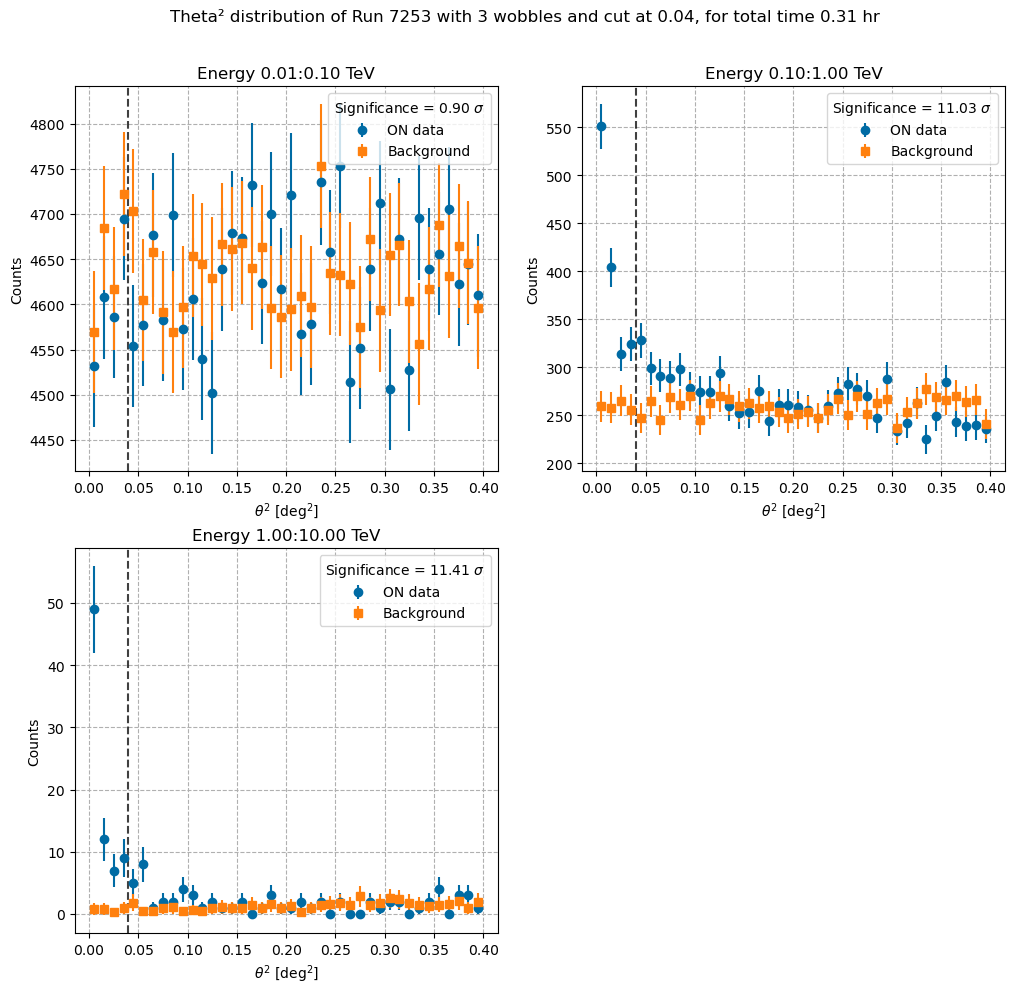

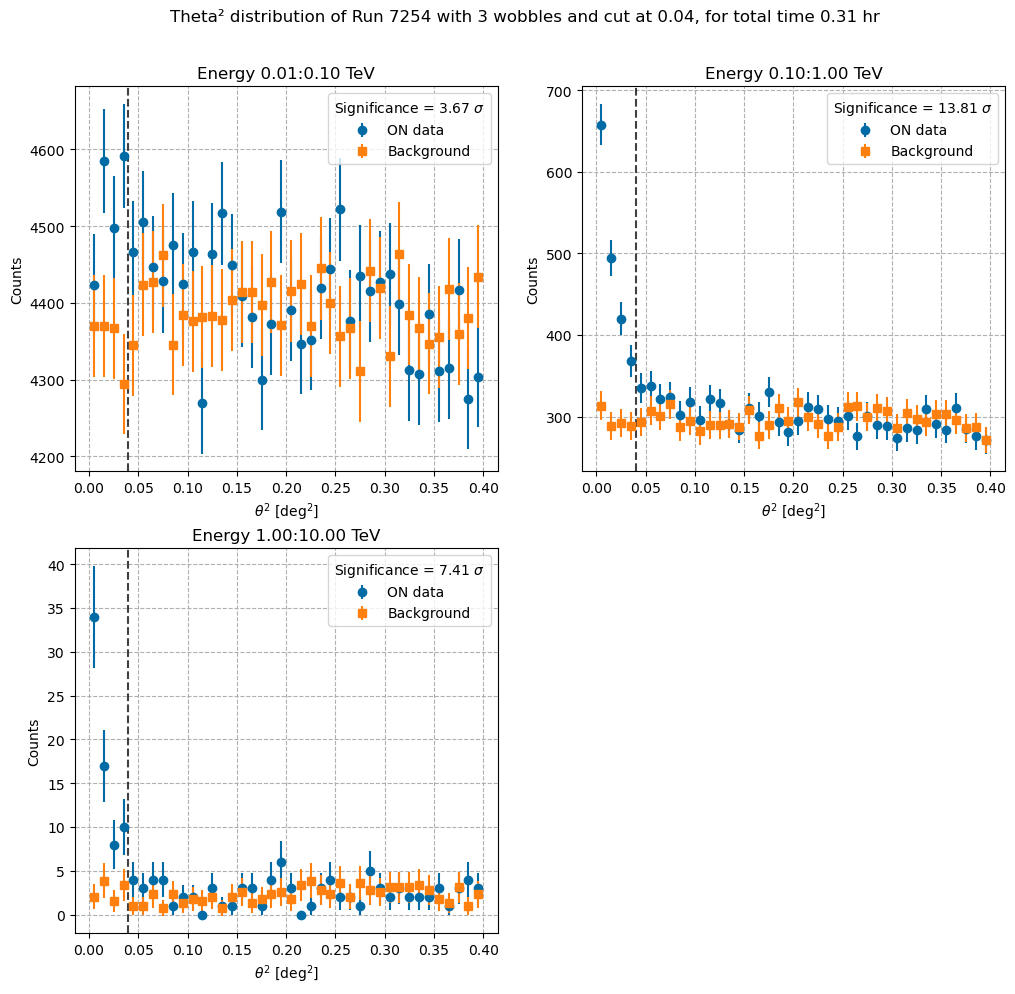

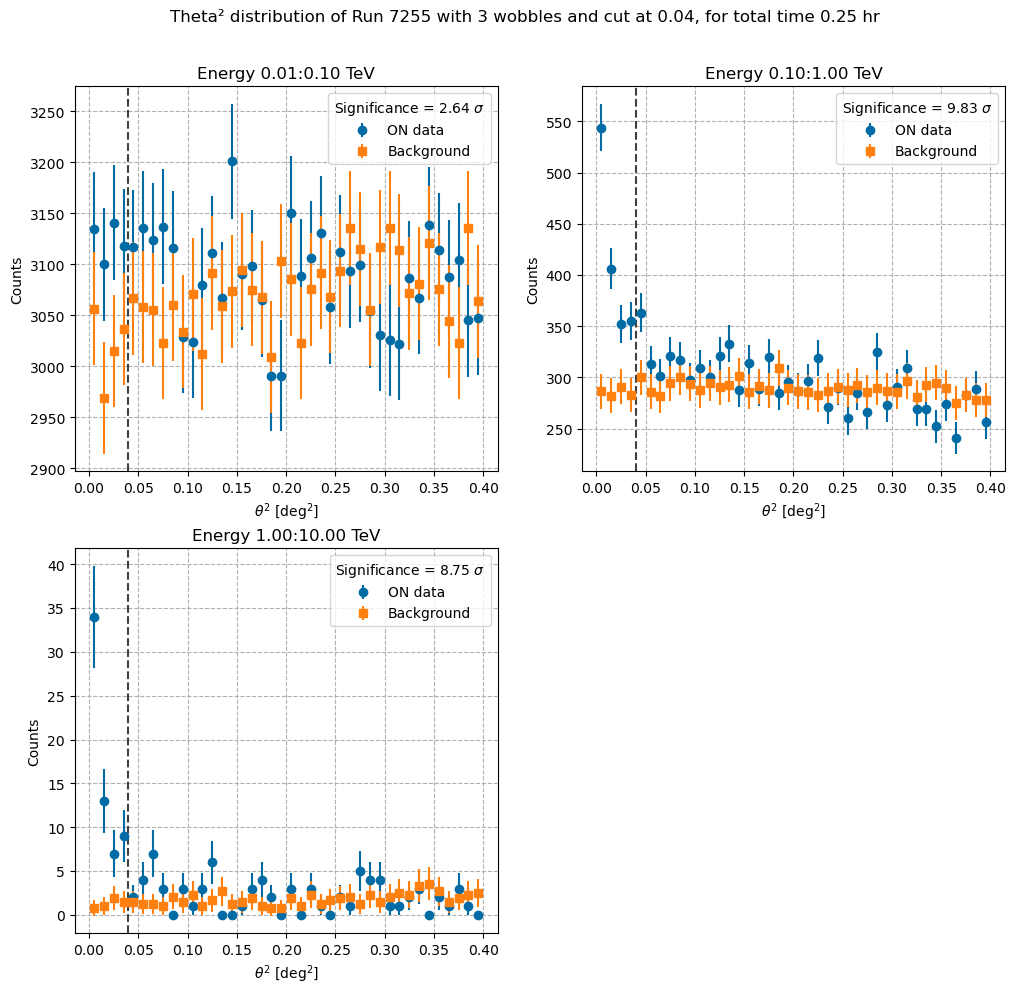

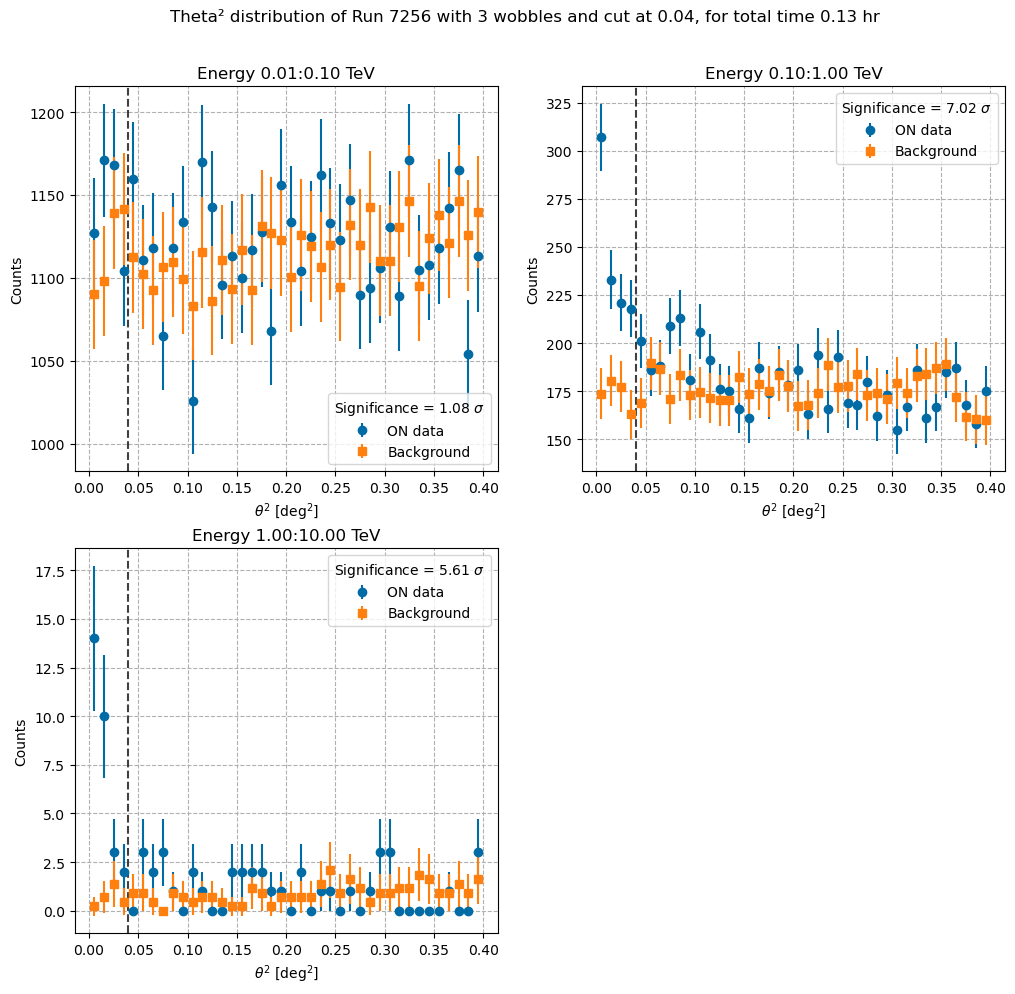

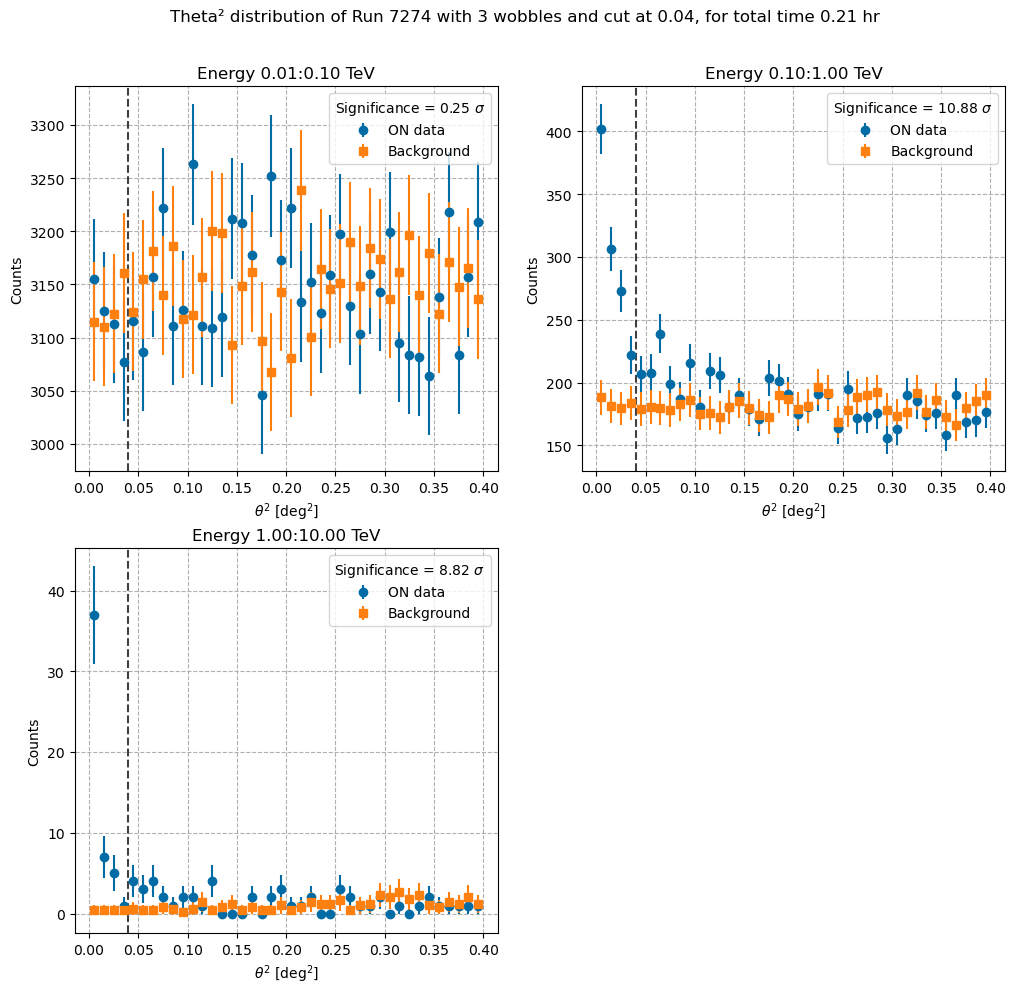

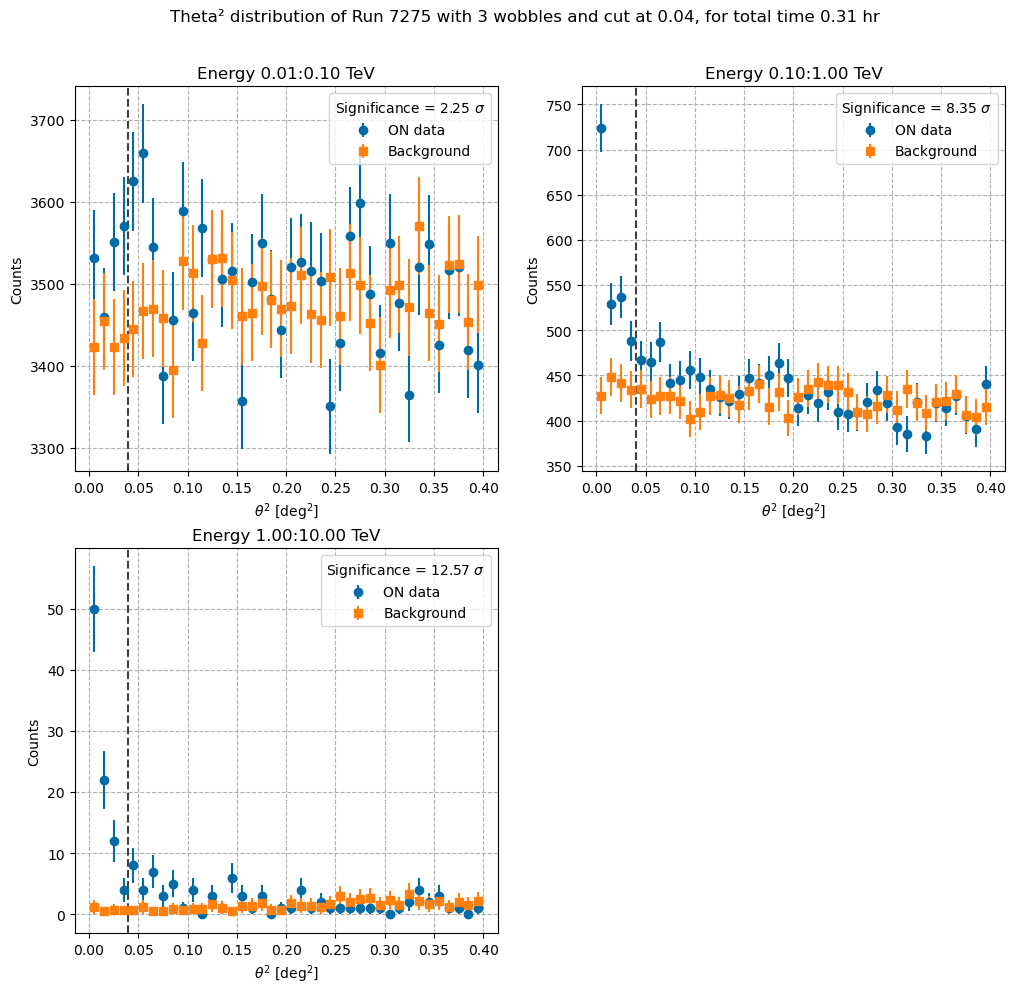

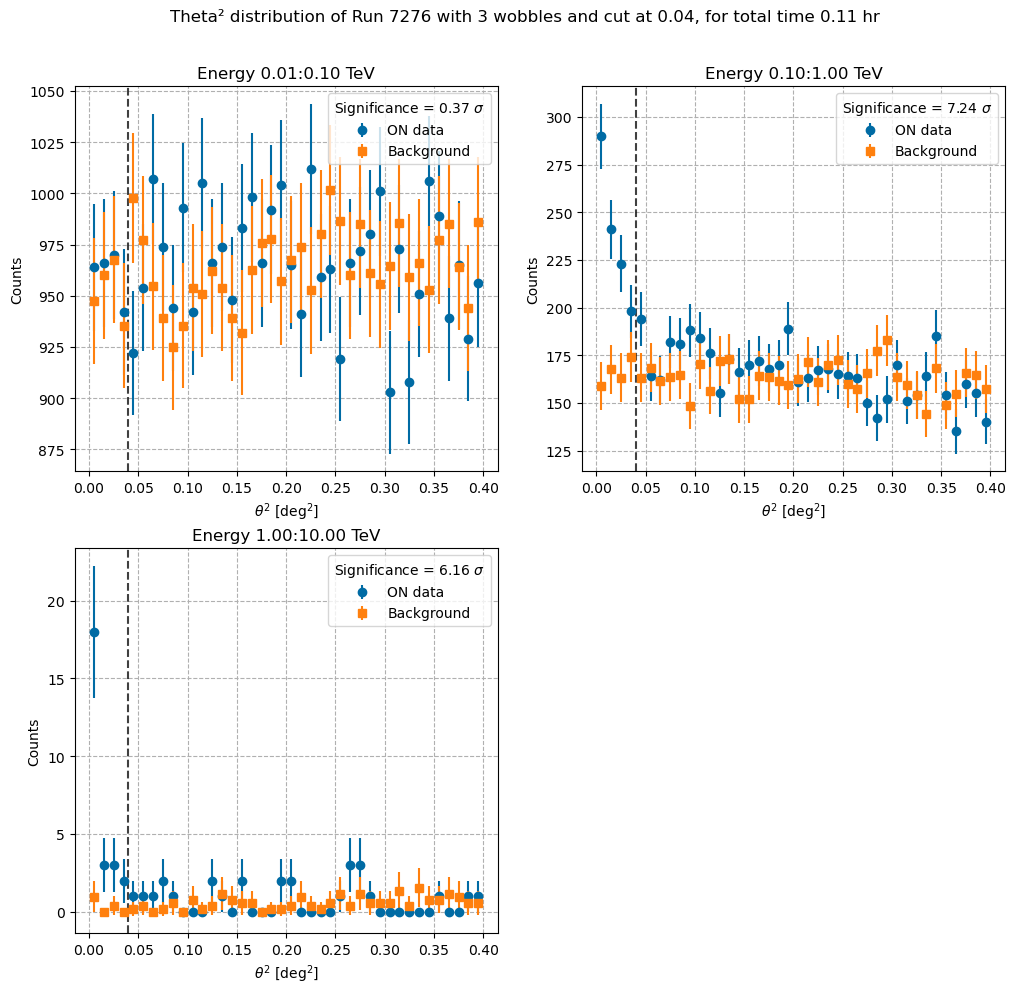

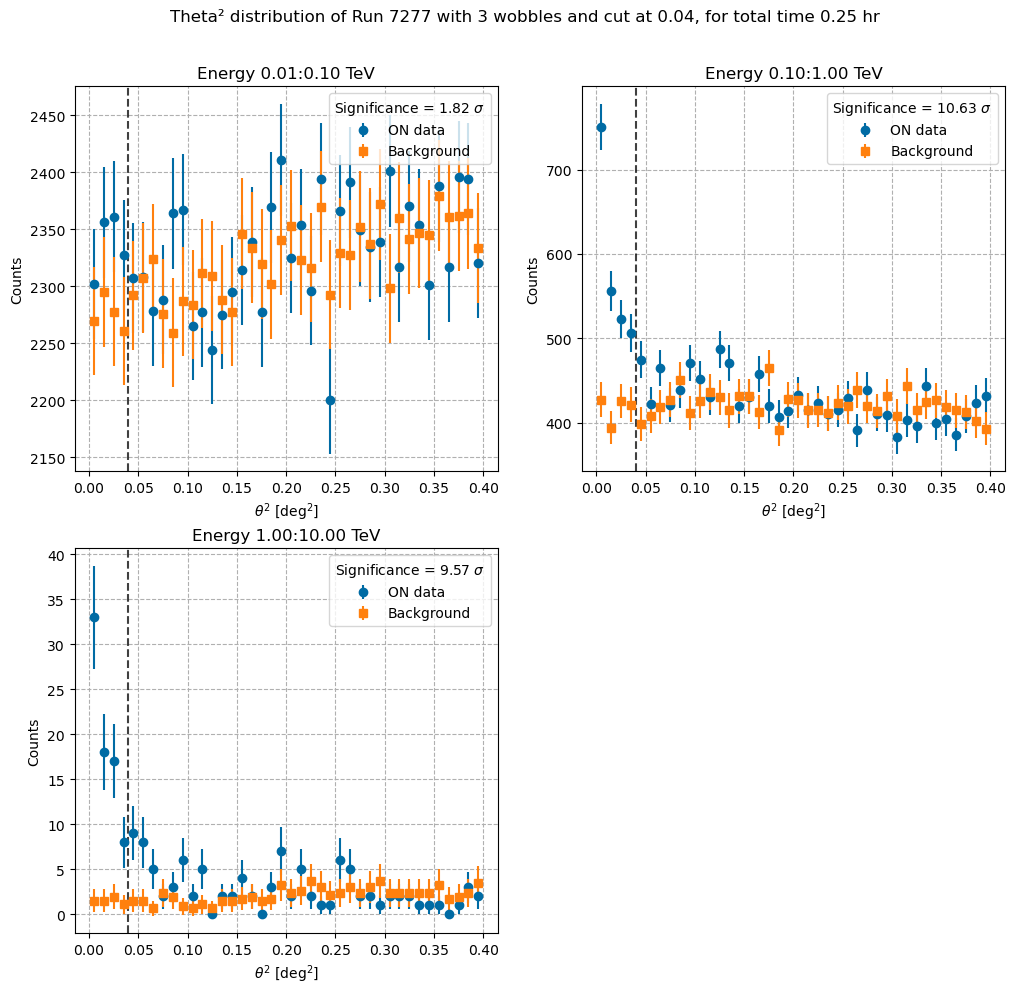

In [31]:
plt.figure(figsize=(10,8))
for i in range(len(observations)):
    
    theta2 = make_theta_squared_table(
        [observations[i]], theta2_axis, e_reco_axis,
        theta2_norm_min, theta2_norm_max, target_position, wobble_pos=wobble_pos
    )
    plot_theta_squared_table(theta2, theta2_cut, custom_style=custom_style, counts_only=counts_plot)


# 6. Theta2 plot for stacked observations (On/Off distributions)

In [32]:
theta2_total = make_theta_squared_table(
    observations, theta2_axis, e_reco_axis, theta2_norm_min, 
    theta2_norm_max, target_position, wobble_pos=wobble_pos, n_wobbles=n_wobbles
)

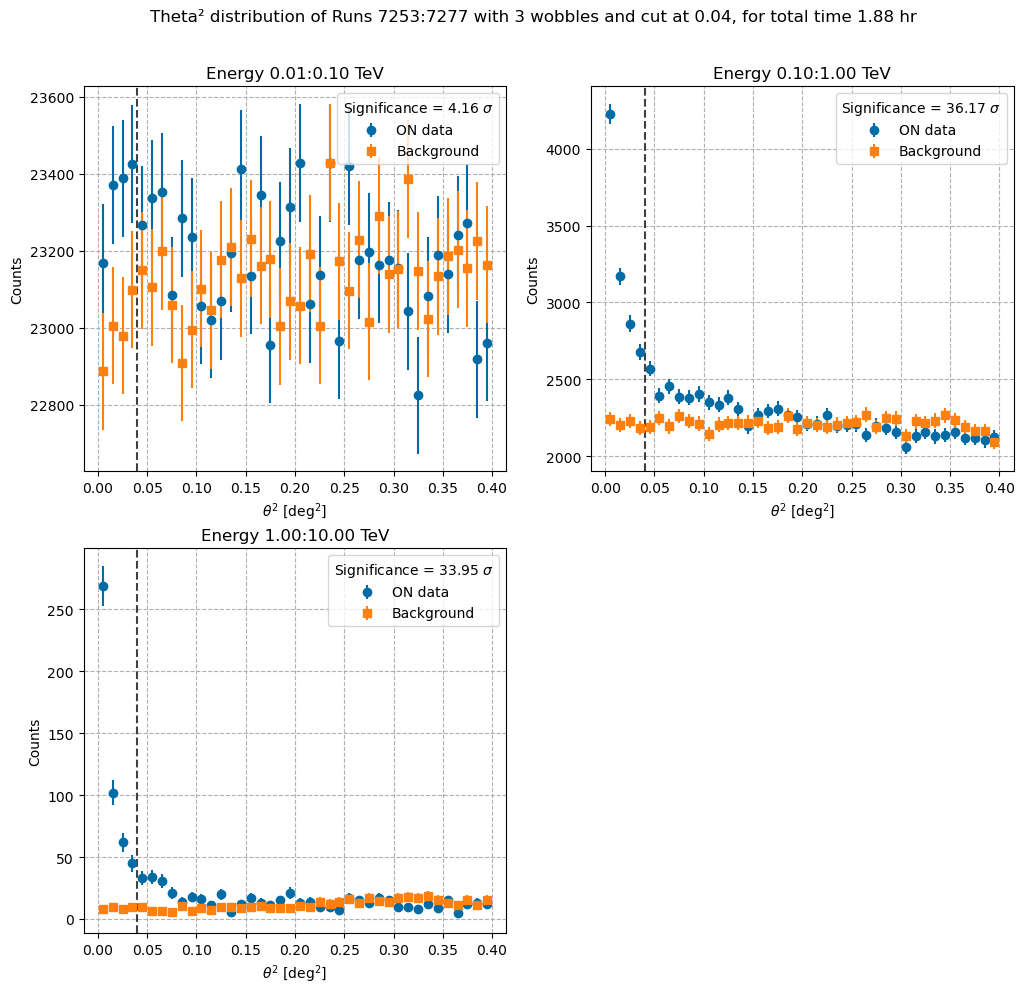

In [33]:
plot_theta_squared_table(theta2_total, theta2_cut, custom_style=custom_style, counts_only=True)

 # 7. Plot just the excess counts

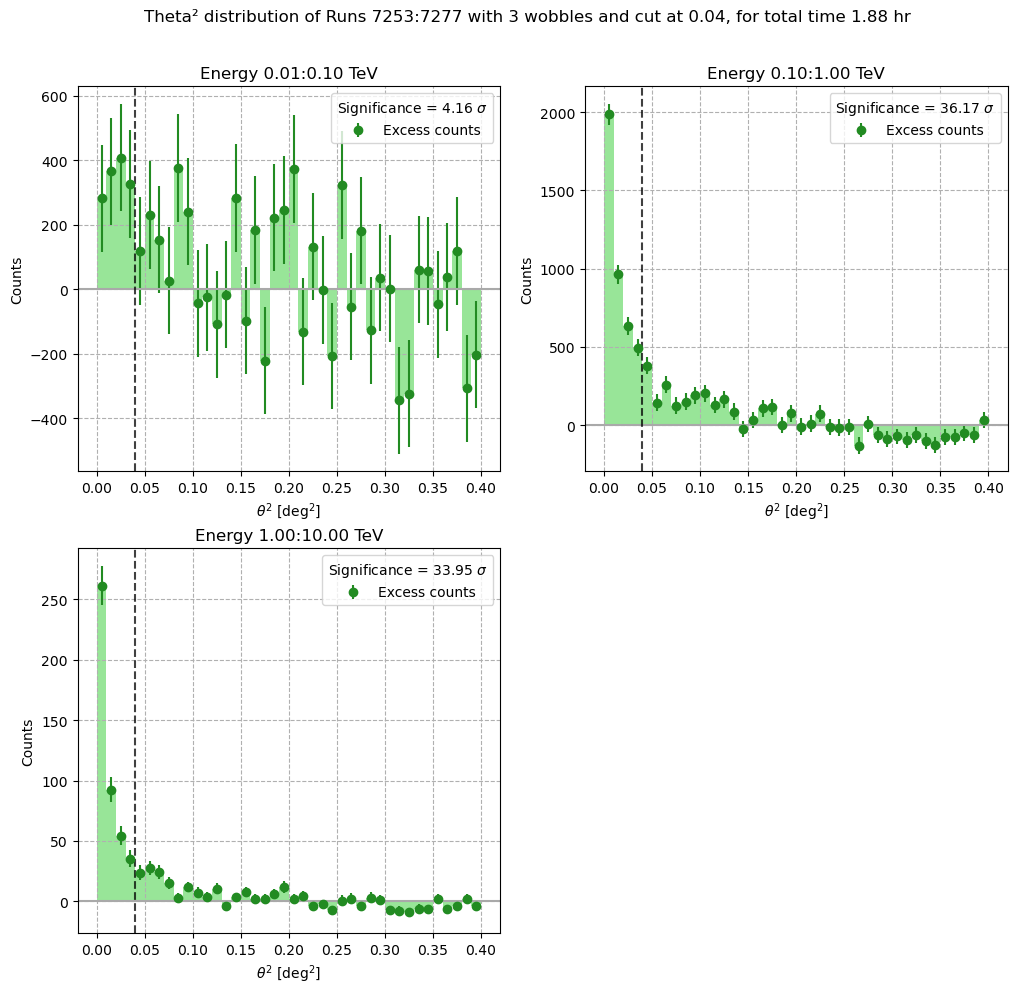

In [34]:
plot_theta_squared_table(theta2_total, theta2_cut, custom_style=custom_style, counts_only=False)